In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F

import torchvision
from torchvision import datasets, transforms
from torchvision.utils import make_grid
print(f'{torchvision.__version__=}')

import matplotlib.pyplot as plt
import numpy as np


torchvision.__version__='0.22.1+cu126'


In [2]:
# print("GPU name:", torch.cuda.get_device_name())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
print(torch.cuda.device_count(), "GPUs available")

Device: cuda
1 GPUs available


# Load MNIST Dataset

Training dataset 60000 samples
Test dataset 10000 samples


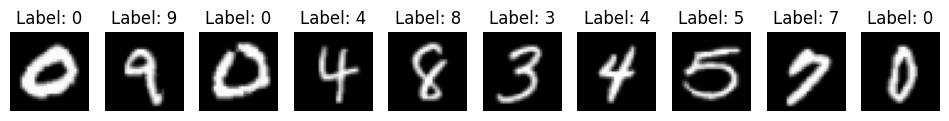

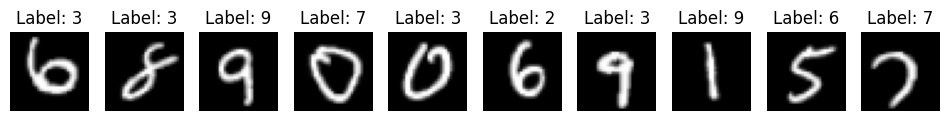

In [3]:
transform = transforms.Compose([transforms.Resize((32, 32)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=(0.5,), std=(0.5,))])
training_data = datasets.MNIST(root='./data_src', train=True, download=True,transform=transform)
test_data = datasets.MNIST(root='./data_src', train=False, download=True, transform=transform)

# show random samples from the dataset
print(f"Training dataset {len(training_data)} samples")
fig, axes = plt.subplots(1, 10, figsize=(12, 4))
for ax in axes.ravel():
    idx = np.random.randint(len(training_data))
    ax.imshow(training_data[idx][0].squeeze(), cmap='gray')
    ax.set_title(f'Label: {training_data[idx][1]}')
    ax.axis('off')

print(f"Test dataset {len(test_data)} samples")
fig, axes = plt.subplots(1, 10, figsize=(12, 4))
for ax in axes.ravel():
    idx = np.random.randint(len(test_data))
    ax.imshow(test_data[idx][0].squeeze(), cmap='gray')
    ax.set_title(f'Label: {training_data[idx][1]}')
    ax.axis('off')

In [4]:
# Define dataloaders
training_dataloader = DataLoader(training_data,
                                 batch_size=64,
                                 shuffle=True,
                                 drop_last=True)
test_dataloader = DataLoader(test_data,
                             batch_size=64,
                             shuffle=False,
                             drop_last=True)

In [10]:
# Say we want 100 diffusion steps
T = 175
# Create a beta schedule that goes from 1e-4 to 0.02
betas = torch.linspace(1e-4, 0.02, T).to(device)
alphas = 1. - betas
alpha_hat = torch.cumprod(alphas, dim=0) # cumulative product

def q_sample(x_0, t, noise=None):
    """
    Forward diffusion (adding noise) step
    x0: original image [batch, 1, 32, 32]
    t: timestep [batch]
    """
    device = x_0.device
    if noise is None:
        noise = torch.randn_like(x_0, device=device)
    alpha_hat_t = alpha_hat[t].to(device)  # [batch]
    sqrt_alpha_hat = torch.sqrt(alpha_hat_t)[:, None, None, None]
    sqrt_one_minus_alpha_hat = torch.sqrt(1 - alpha_hat_t)[:, None, None, None]
    return sqrt_alpha_hat * x_0 + sqrt_one_minus_alpha_hat * noise

# Forward process in action where we corrupt the images

$$
x_t = \sqrt \alpha_t x_0 + \sqrt{1 - \alpha_t} \epsilon
$$

where,
- $x_0$ is the input image,
- $\epsilon$ is the noise sampled from a standard normal distribution,
- $\alpha_t$ is a hyperparameter that controls the amount of noise added at each time step.



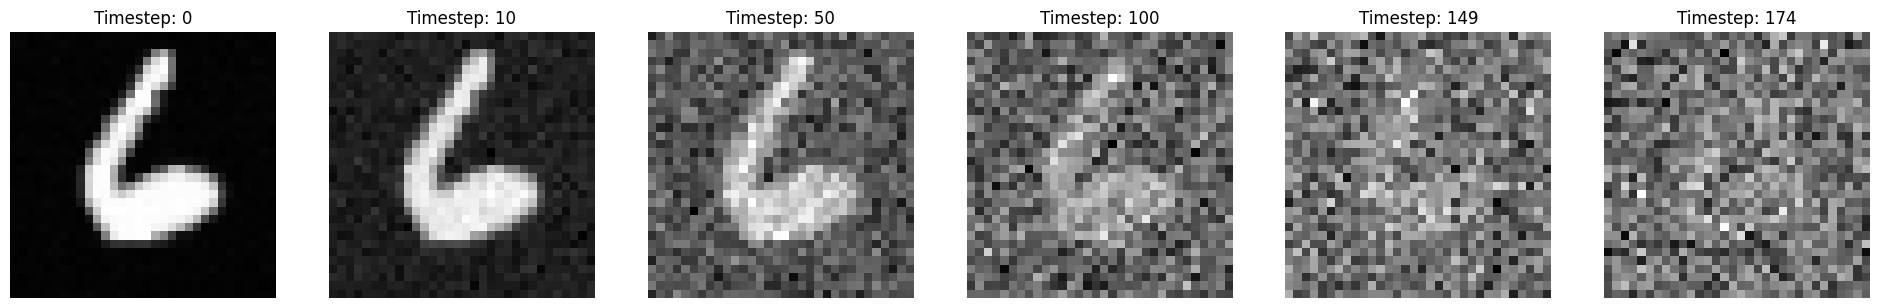

In [11]:
# when t is small, x_t is similar to x_0
# when t is large, x_t is similar to random noise
images = next(iter(training_dataloader))[0] # get images
timesteps = [0, 10, 50, 100, 149, 174]
noisy_images = []
for timestep in timesteps:
    t = torch.full((images.shape[0], ), timestep, dtype=torch.long)
    noisy_images.append(q_sample(images, t)) # get noisy images at timestep

# plot noisy images
fig, axes = plt.subplots(1, len(timesteps), figsize=(4 * len(timesteps), 4))
for t, ax, noisy_images in zip(timesteps, axes.ravel(), noisy_images):
    ax.imshow(noisy_images[63].squeeze(), cmap='gray') # plot last (63) image of the batch
    ax.axis('off')
    ax.set_title(f'Timestep: {t}')

### For the reverse process, we train a neural network to predict the noise that was added at $t$


$$
\mathcal{L} = \mathbb{E}_{x_0, \epsilon, t} \left[ \| \epsilon - \epsilon_\theta(x_t, t) \|^2 \right]
$$

where,
- $x_0$ is the original image,
- $x_t$ is the noisy image at timestep $t$,
- $\epsilon$ is the noise added to the image,
- $\epsilon_\theta(x_t, t)$ is the predicted noise by the neural network.

So the network job is to: "Given the noisy image at timestep $t$, predict the noise $\epsilon$ that was added to obtain it."


In [12]:
print(images.shape)

torch.Size([64, 1, 32, 32])


We write a simple CNN model, where:

Input to the model: a noisy image $x_t$ and timestep $t$

Output of the model: the model's guess for the noise we added (same shape as $x_t$)

In [14]:
class SimpleDiffusionModel(nn.Module):
    def __init__(self, T, device='cpu'):
        super().__init__()
        self.T = T
        self.device = device
        # We learn a 64-dimensional embedding for each timestep 0 to T - 1
        self.time_embed = nn.Embedding(self.T, 64).to(device) # 64 because we add it after conv2
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1).to(device)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1).to(device)
        self.conv3 = nn.Conv2d(64, 32, 3, padding=1).to(device)
        self.conv4 = nn.Conv2d(32, 1, 3, padding=1).to(device)

    def forward(self, x, t):
        # t is [batch], get embedding and broadcast to image
        t_embed = self.time_embed(t)
        t_embed = t_embed[:, :, None, None] # [batch, 64, 1, 1]

        h = F.relu(self.conv1(x))
        h = F.relu(self.conv2(h))

        # Inject time info
        h = h + t_embed
        h = F.relu(self.conv3(h))
        out = self.conv4(h)
        return out # predicted noise

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = SimpleDiffusionModel(T, device=device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(200):
    for x0, _ in training_dataloader:
        x0 = x0.to(device)
        t = torch.randint(0, T, (x0.shape[0],), device=device)
        actual_noise = torch.randn_like(x0, device=device)
        xt = q_sample(x0, t, actual_noise)  # noisy image
        predicted_noise = model(xt, t)
        loss = F.mse_loss(predicted_noise, actual_noise)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("epoch", epoch, "loss", loss.item())

Using device: cuda
epoch 0 loss 0.0884106308221817
epoch 1 loss 0.08679406344890594
epoch 2 loss 0.06550315022468567
epoch 3 loss 0.06858976930379868
epoch 4 loss 0.05544297397136688
epoch 5 loss 0.06431210041046143
epoch 6 loss 0.05814163386821747
epoch 7 loss 0.05605277419090271
epoch 8 loss 0.05370078980922699
epoch 9 loss 0.057938043028116226
epoch 10 loss 0.0462924987077713
epoch 11 loss 0.05173151195049286
epoch 12 loss 0.057938966900110245
epoch 13 loss 0.06510921567678452
epoch 14 loss 0.06399921327829361
epoch 15 loss 0.05191607028245926
epoch 16 loss 0.05764871835708618
epoch 17 loss 0.05858638137578964
epoch 18 loss 0.05062706023454666
epoch 19 loss 0.05227960646152496
epoch 20 loss 0.04562676325440407
epoch 21 loss 0.04970751702785492
epoch 22 loss 0.04989159107208252
epoch 23 loss 0.05789808928966522
epoch 24 loss 0.0533309243619442
epoch 25 loss 0.05191567540168762
epoch 26 loss 0.05116770416498184
epoch 27 loss 0.06343508511781693
epoch 28 loss 0.0495881587266922
epoch 2

## Now the reverse update
$$
x_t = \sqrt \alpha_t x_0 + \sqrt{1 - \alpha_t} \epsilon
$$
Rearranging gives:
$$
\epsilon = 1/\sqrt{1 - \alpha_t}(x_t - \sqrt \alpha_t x_0)
$$
Now, during sampling, we don't have access to $x_0$, but we have a model that predicts $\epsilon$.
So we can rearrange the equation to solve for $x_0$:

$$
x_0 = 1/\sqrt{\alpha_t}(x_t - \sqrt{1 - \alpha_t} \epsilon)
$$

In [28]:
@torch.no_grad()
def p_sample(model, x_t, t):
    """Sample x_{t-1} from x_t"""
    sqrt_one_minus_alpha_hat_t = torch.sqrt(1 - alpha_hat[t]).to(x_t.device)[:, None, None, None]
    sqrt_recip_alpha_t = 1.0 / torch.sqrt(alphas[t]).to(x_t.device)[:, None, None, None]
    # predict noise
    eps_theta = model(x_t, t)
    x = (x_t - sqrt_one_minus_alpha_hat_t * eps_theta) * sqrt_recip_alpha_t
    return x

@torch.no_grad()
def sample(model, n=16):
    model.eval()
    x = torch.randn(n, 1, 32, 32).to(device)  # start from pure noise
    for t in reversed(range(70)):
        x = p_sample(model, x, torch.tensor([t]*n).to(model.device))
    return x

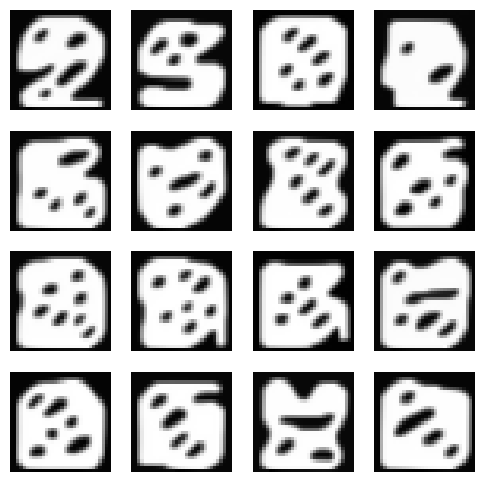

In [29]:
import matplotlib.pyplot as plt

samples = sample(model, n=16).cpu()

# visualize
fig, axes = plt.subplots(4, 4, figsize=(6,6))
for i, ax in enumerate(axes.flat):
    ax.imshow(samples[i,0], cmap="gray")
    ax.axis("off")
plt.show()